# ME2105 Meteorologi Dinamik I (Semester III 2019/2020)
# Teori Dinamika Monsun

## Sesi Ke-10 : Interaksi ENSO-Monsun



### Bahan bacaan tentang indeks-indeks ENSO:

[Climate Data Guide](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni)


[Climate.gov](https://www.climate.gov/news-features/blogs/enso/why-are-there-so-many-enso-indexes-instead-just-one#:~:text=At%20NOAA%2C%20the%20official%20ENSO,other%20ways%20of%20measuring%20ENSO)

Data SST dari [NOAA Extended Reconstructed SST V5](https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html)

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import numpy as np
import xarray as xr


In [2]:
#data uwnd,vwnd,precip, dan sst
V=xr.open_dataset('Data/vwnd.mon.mean.nc')
U=xr.open_dataset('Data/uwnd.mon.mean.nc')
Pr=xr.open_dataset('Data/prate.sfc.mon.mean.nc')
SST=xr.open_dataset('Data/sst.mnmean.nc')


In [5]:
U

<xarray.Dataset>
Dimensions:  (lat: 73, level: 17, lon: 144, time: 870)
Coordinates:
  * level    (level) float32 1000.0 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2020-06-01
Data variables:
    uwnd     (time, level, lat, lon) float32 ...
Attributes:
    title:          monthly mean u wind from the NCEP Reanalysis
    description:    Data from NCEP initialized reanalysis (4x/day).  These ar...
    platform:       Model
    Conventions:    COARDS
    NCO:            20121012
    history:        Mon Jul  5 22:36:33 1999: ncrcat uwnd.mon.mean.nc /Datase...
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

Hitung Indeks Nino3.4. Algoritma (Ref: Climate Data Guide):
> Nino X Index computation: (a) Compute area averaged total SST from Niño X region; (b) Compute monthly climatology (e.g., 1950-1979) for area averaged total SST from Niño X region, and subtract climatology from area averaged total SST time series to obtain anomalies; (c) Smooth the anomalies with a 5-month running mean; (d) Normalize the smoothed values by its standard deviation over the climatological period.

In [36]:
#Indeks Nino3.4 (5N-5S, 170W-120W)
#Compute area averaged total SST from Niño X region;
ts_sst=SST.sst.sel(lon=slice(360-170,360-120),lat=slice(5,-5)).mean(axis=(1,2))
#Compute monthly climatology (e.g., 1950-1979) for area averaged total SST from Niño X region
clim_sst=ts_sst.sel(time=slice('1950-1-1','1979-12-1')).groupby('time.month').mean(dim='time')
#and subtract climatology from area averaged total SST time series to obtain anomalies; 
anom_sst=ts_sst.groupby('time.month')-clim_sst
#Smooth the anomalies with a 5-month running mean
anom_sst_smooth=anom_sst.rolling(time=5).mean()
#Normalize the smoothed values by its standard deviation over the climatological period
std_anom=anom_sst_smooth.sel(time=slice('1950-1-1','1979-12-1')).std(dim='time')
nino=anom_sst_smooth/std_anom

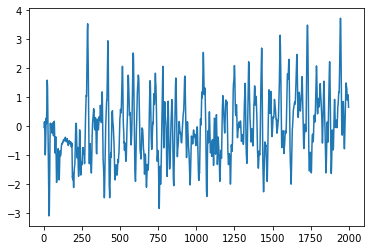

In [8]:
plt.plot(nino)

In [10]:
nino

<xarray.DataArray (time: 1998)>
array([       nan,        nan,        nan, ..., 1.03591513, 0.86493144,
       0.65388374])
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2020-06-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 8 9 10 11 12 1 2 3 4 5 6

Menentukan event El-Nino (warm) dan La-Nina (cold).
> Niño 3.4 (5N-5S, 170W-120W):  The  Niño 3.4 anomalies may be thought of as representing the average equatorial SSTs across the Pacific from about the dateline to the South American coast.  The Niño 3.4 index typically uses a 5-month running mean, and El Niño or La  Niña events are defined when the  Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more.

In [37]:
#1948-2019
ndays = Pr.time.dt.days_in_month
prec=Pr.prate.sel(time=slice("1948-1-1","2019-12-1"))*3600*24*ndays
u=U.uwnd.sel(time=slice("1948-1-1","2019-12-1"))
v=V.vwnd.sel(time=slice("1948-1-1","2019-12-1"))
#index
nino34=nino.sel(time=slice("1948-1-1","2019-12-1"))

In [50]:
warm=nino34>0.4
cold=nino34<-0.4

prec_warm=prec[warm,:,:]
prec_cold=prec[cold,:,:]

prec_warm_clim=prec_warm.groupby('time.season').mean(dim='time')
prec_cold_clim=prec_cold.groupby('time.season').mean(dim='time')

diff_jja=prec_warm_clim.sel(season='JJA')

# prec_warm
# warm

## Eksperimen 1: reproduksi Figure 2 di EAS:ENSO–Monsoon Interactions

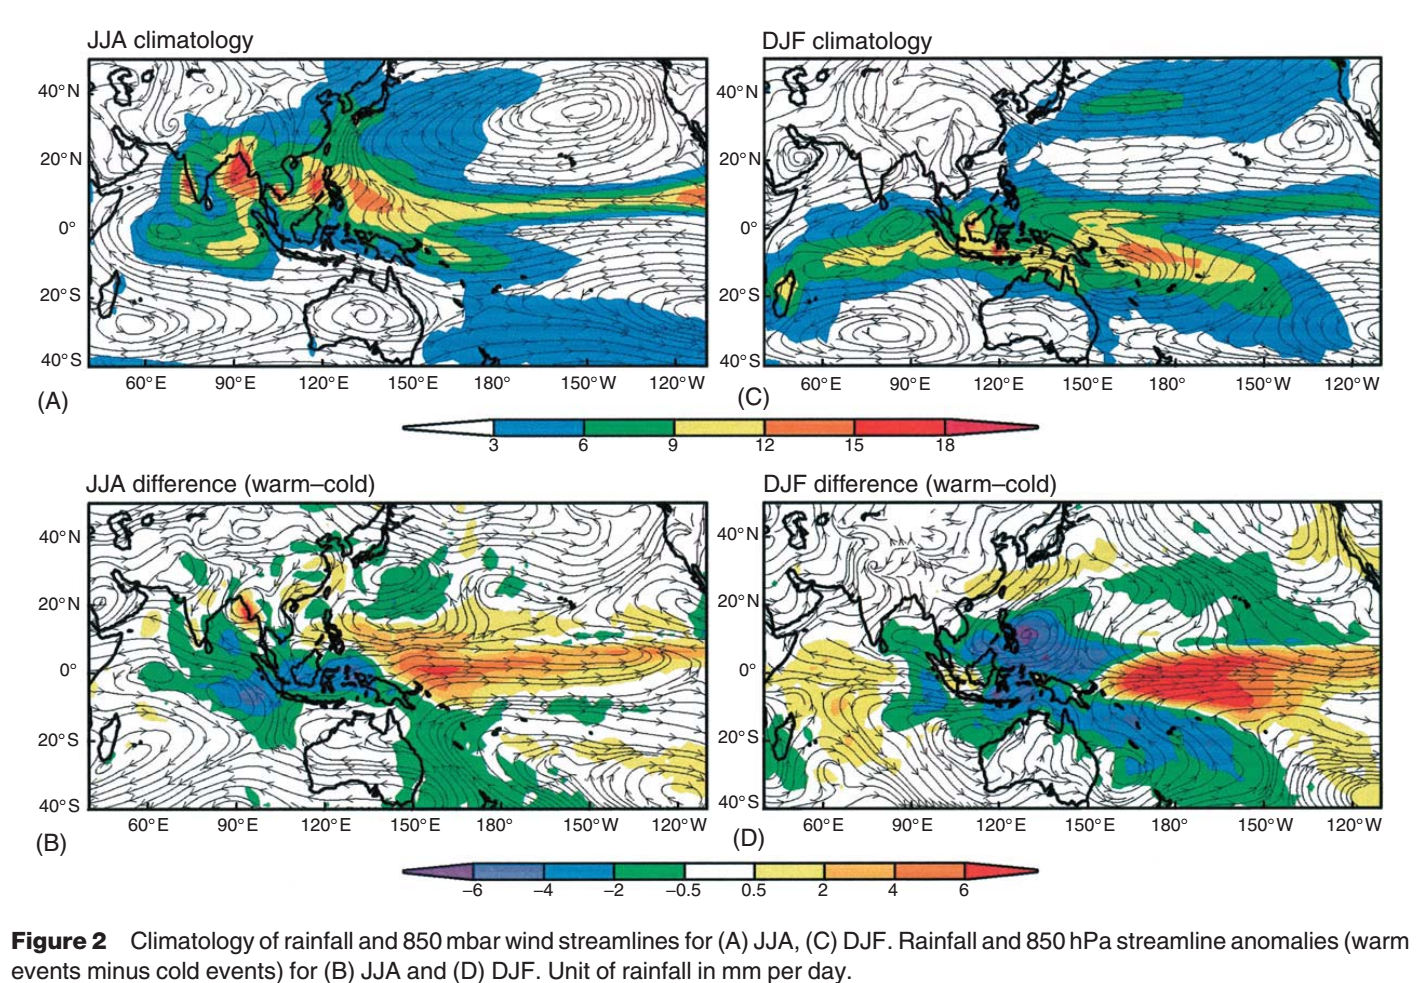

In [15]:
#JJA climatology
prec_clim=prec.groupby('time.season').mean(dim='time')
u850_clim=u.sel(level=850).groupby('time.season').mean(dim='time')
v850_clim=v.sel(level=850).groupby('time.season').mean(dim='time')

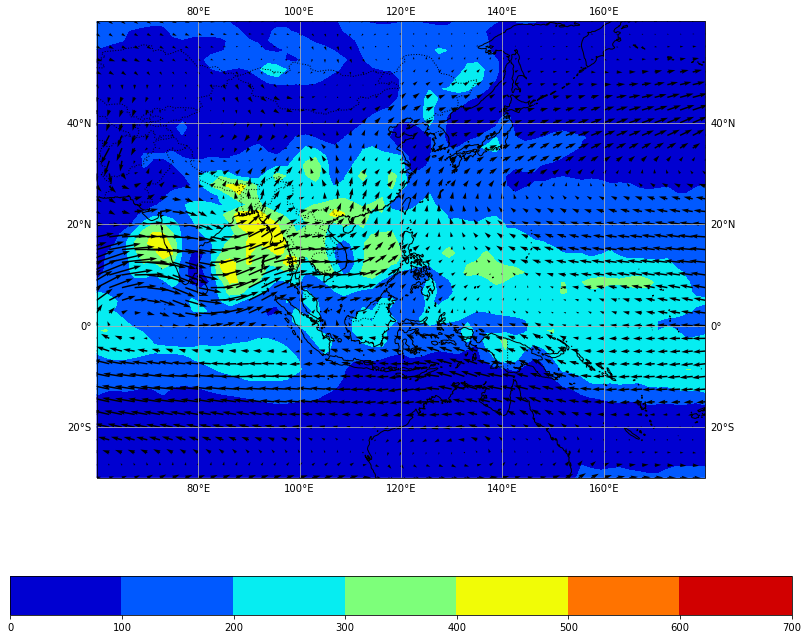

In [16]:
#projection
mproj=ccrs.PlateCarree(central_longitude=0)
#figure dan axes 
fig = plt.figure(1, figsize=(14, 12))
ax = plt.axes(projection=mproj)

#contourfill magnitude
cf=ax.contourf(prec_clim.lon, prec_clim.lat,prec_clim.sel(season='JJA'), 
               #cmap=plt.cm.bwr,
               cmap=plt.cm.jet,
               transform=mproj)
cb = plt.colorbar(cf, orientation='horizontal')

#vektor angin
[xlon,ylat]=np.meshgrid(u850_clim.lon,u850_clim.lat)
qui=ax.quiver(xlon,ylat,u850_clim.sel(season='JJA'),v850_clim.sel(season='JJA'),
              transform=mproj,
              units='xy',
              scale=2.5)

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent((60,180, -30, 60),crs=mproj)
#grid line
ax.gridlines(draw_labels=True)
